# Лабораторная работа №1 по дисциплине "Системы обработки больших данных"
## Подключаем библиотеки и датасет. Определяем колонки по типу, выводим их, а также выполняем вывод части данных

In [1]:
# Import other modules not related to PySpark
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
from pyspark.sql import functions as F  # Importing necessary functions
# This helps auto print out the items without explixitly using 'print'
from pyspark.sql.functions import when, col
from pyspark.sql.functions import mean
from pyspark.sql.functions import avg, col, stddev, mean, min, max
from pyspark.sql.functions import percentile_approx, min, max, mean, stddev
from pyspark.sql.functions import count
from pyspark.sql.window import Window
import pyspark.sql.functions as F
from pyspark.sql.functions import length
from pyspark.sql.functions import lag
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import round
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline

In [2]:
# Import PySpark related modules
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size, array_contains\
, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *

MAX_MEMORY = '8G'
# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Pyspark guide") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()
filename_data = 'data/iran_201906_2_tweets_csv_hashed.csv'
# Load the main data set into pyspark data frame 
df = spark.read.csv(filename_data,header=True, mode="DROPMALFORMED", inferSchema=True)
from pyspark.sql.functions import col, array

df = df.drop("user_profile_description", "account_creation_date", "user_reported_location", "account_language", "tweet_text", "tweet_time", "tweet_client_name", "in_reply_to_userid", "in_reply_to_tweetid", "quoted_tweet_tweetid", "retweet_userid", "retweet_tweetid", "latitude", "longitude", "user_mentions", "poll_choices", "hashtags", "urls", "user_screen_name", "user_display_name", "user_profile_url")

df = df.withColumn("tweetid", col("tweetid").cast(LongType()))
df = df.withColumn("userid", col("userid").cast(LongType()))
df = df.withColumn("follower_count", col("follower_count").cast(IntegerType()))
df = df.withColumn("following_count", col("following_count").cast(IntegerType()))
df = df.withColumn("quote_count", col("quote_count").cast(IntegerType()))
df = df.withColumn("reply_count", col("reply_count").cast(IntegerType()))
df = df.withColumn("like_count", col("like_count").cast(IntegerType()))
df = df.withColumn("retweet_count", col("retweet_count").cast(IntegerType()))
df = df.withColumn("is_retweet", col("is_retweet").cast("boolean"))

print('Data frame type: ' + str(type(df)))

total_twitter_count = df.count()
print('Rows count:', total_twitter_count)

Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>
Rows count: 7417013


### Выполняем разведочный анализ датасета с определением:

#### 1. Типы признаков в датасете:

In [3]:
print('Data overview')
df.printSchema()
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Data overview
root
 |-- tweetid: long (nullable = true)
 |-- userid: long (nullable = true)
 |-- follower_count: integer (nullable = true)
 |-- following_count: integer (nullable = true)
 |-- tweet_language: string (nullable = true)
 |-- is_retweet: boolean (nullable = true)
 |-- quote_count: integer (nullable = true)
 |-- reply_count: integer (nullable = true)
 |-- like_count: integer (nullable = true)
 |-- retweet_count: integer (nullable = true)

Columns overview


,Column Name,Data type
0,tweetid,bigint
1,userid,bigint
2,follower_count,int
3,following_count,int
4,tweet_language,string
5,is_retweet,boolean
6,quote_count,int
7,reply_count,int
8,like_count,int
9,retweet_count,int


##### После анализа фрейма было решено оставить 12 колонок для осуществления анализа. Разберем типы признаков:
1. tweetid (целое число): Это идентификатор твита. Категориальный признак и является уникальным идентификатором для каждого твита.

2. userid (целое число): Это идентификатор пользователя. Категориальный признак и является уникальным идентификатором для каждого пользователя.

3. follower_count (целое число): Количество подписчиков у пользователя. Это количественный (непрерывный) признак, так как это число, которое может принимать широкий диапазон значений.

4. following_count (целое число): Количество пользователей, на которых подписан данный пользователь. Тоже количественный признак.

5. tweet_language (строка): Язык твита. Категориальный признак, представляющий язык твита, например, "en" для английского.

6. is_retweet (логическое значение): Это булевый признак, представляющий, является ли твит ретвитом или нет.

7. quote_count (целое число): Количество цитирований для указанного твита. Количественный признак.

8. reply_count (целое число): Количество ответов для указанного твита. Количественный признак.

9. like_count (целое число): Количество лайков для указанного твита. Количественный признак.

10. retweet_count (целое число): Количество ретвитов для указанного твита. Количественный признак.

#### 2. Выявление пропущенных значений и их устранение:

##### Определяем пропущенные значения:

In [4]:
string_columns = ['tweet_language', 'is_retweet']
numeric_columns = ['tweetid', 'userid', 'follower_count', 'following_count', "quote_count", "reply_count", "like_count", "retweet_count"]

def view_missing_values_in_columns(string_columns, numeric_columns):
    missing_values = {}
    for index, column in enumerate(df.columns):
        if column in string_columns:
            missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
        else: 
            missing_count = df.where(col(column).isin([None,np.nan]) | col(column).isNull()).count()
        missing_values.update({column:missing_count})
    
    return missing_values

pd.DataFrame.from_dict([view_missing_values_in_columns(string_columns, numeric_columns)])

,tweetid,userid,follower_count,following_count,tweet_language,is_retweet,quote_count,reply_count,like_count,retweet_count
0,5233116,5823087,6235316,6359126,4935972,6705323,7110660,7109996,7109808,7109766


##### Осуществляем удаление найденных пропущенных значений:

In [5]:
df = df.dropna()
print('Устранение пропущенных значений прошло успешно')

Устранение пропущенных значений прошло успешно


##### Проверяем наличие пропущенных значений после их удаления:

In [6]:
pd.DataFrame.from_dict([view_missing_values_in_columns(string_columns, numeric_columns)])

,tweetid,userid,follower_count,following_count,tweet_language,is_retweet,quote_count,reply_count,like_count,retweet_count
0,0,0,0,0,0,0,0,0,0,0


#### 3. Определение выбросов и их устранение:

##### После обработки пропущенных значений формируем статистических данных для числовых столбцов датафрейма, чтобы определить оставшееся количество строк в фрейме:

In [7]:
df.select(df.follower_count, df.following_count, df.quote_count, df.reply_count, df.like_count, df.retweet_count).describe().toPandas()

,summary,follower_count,following_count,quote_count,reply_count,like_count,retweet_count
0,count,199496,199496,199496,199496,199496,199496
1,mean,30182.236355616154,5297.203778521875,0.03739423346834022,0.36610257849781447,4.352809078878774,0.5427176484741548
2,stddev,44795.3600684094,3713.177710685217,2.2106979300823193,4.259650435247733,41.23013871409342,5.707711377878247
3,min,0,0,0,0,0,0
4,max,158248,12022,668,1156,3508,460


##### Осуществим обнаружение и удаление выбросов методом межквартильного интервала (Нахождение 25% и 75% квартилей, межквартильного диапазона):
##### Данные колонок "quote_count", "reply_count", "like_count", "retweet_count" решено было не удалять, т.к. во всех датасетах это приводит к тому, что все уходит по нулям, т.к. на большинстве записей нет никаких реакций.

In [8]:
outlier_columns = ['follower_count', 'following_count']
for column in outlier_columns:
    Q1 = df.approxQuantile(column, [0.25], relativeError=0)[0]
    Q3 = df.approxQuantile(column, [0.75], relativeError=0)[0]
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df.filter(col(column).between(lower_bound, upper_bound))

df.select(['follower_count', 'following_count', 'quote_count', 'reply_count', 'like_count', 'retweet_count']).describe().toPandas()

,summary,follower_count,following_count,quote_count,reply_count,like_count,retweet_count
0,count,174266,174266,174266,174266,174266,174266
1,mean,14143.411692470132,5001.930870049235,0.04207361160524715,0.39723755637932817,4.912053986434531,0.5267808981671698
2,stddev,4691.179063080544,3716.542666551062,2.365007475243776,4.550271819685948,44.05023816370654,5.561052115001351
3,min,0,0,0,0,0,0
4,max,20874,12022,668,1156,3508,460


##### Формируем "ящики с усами" (boxspot-ы) для проверки работоспособности метода межквартильного интервала:

<Axes: >

Text(0.5, 1.0, 'Boxplot of follower_count')

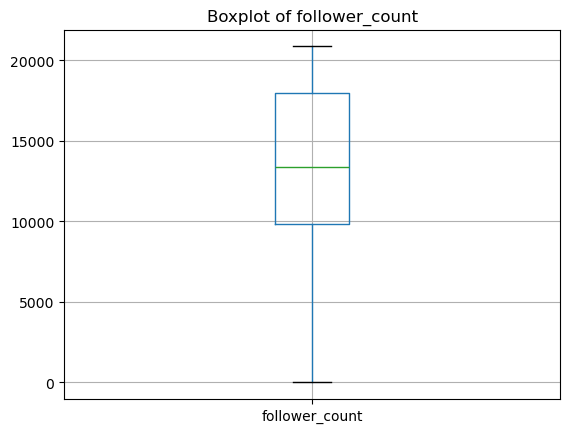

<Axes: >

Text(0.5, 1.0, 'Boxplot of following_count')

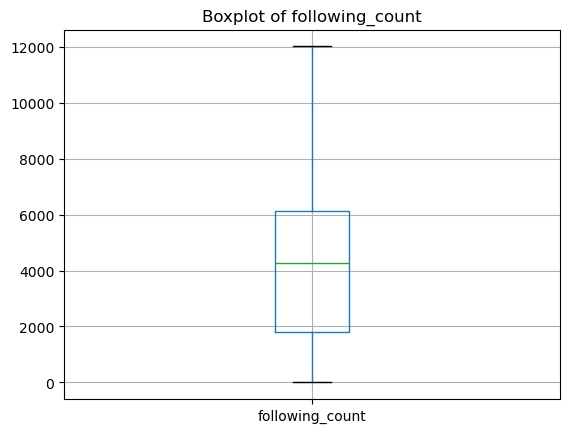

In [9]:
pandas_df = df.toPandas()
for column in outlier_columns:
    pandas_df.boxplot(column=column)
    plt.title(f'Boxplot of {column}')
    plt.show()

#### 4. Расчет статистических показателей признаков (средних, квартилей и т.д.):

##### Выведем типы признаков:

In [10]:
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Columns overview


,Column Name,Data type
0,tweetid,bigint
1,userid,bigint
2,follower_count,int
3,following_count,int
4,tweet_language,string
5,is_retweet,boolean
6,quote_count,int
7,reply_count,int
8,like_count,int
9,retweet_count,int


##### Для реализации этого пункта было решено разобрать категориальные, бинарные и количественные признаки:

##### Обработаем колонки количественных признаков, а также по одной колонке категориального и одной колонки бинарного признака. Начнём с количественных признаков: 

##### Статистические показатели обширны, вот основные из них:
1. Среднее (Mean): Обычно является первым показателем, который рассчитывается для числовых данных. Среднее значение предоставляет информацию о центре распределения данных.

2. Медиана (Median): Это значение, которое делит ваш набор данных на две равные части. Она устойчива к выбросам в данных и используется для оценки "среднего" значения, если данные имеют асимметричное распределение.

3. Квартили (Quartiles): Квартили представляют собой три точки данных, которые делят упорядоченный набор данных на четыре равные части. 25-й квартиль - это значение, которое меньше или равно 25% данных, а 75-й квартиль - это значение, которое меньше или равно 75% данных.

4. Мода (Mode): Значение, которое встречается наиболее часто в вашем наборе данных. Мода полезна для определения наиболее распространенных значений в категориальных данных.

5. Стандартное отклонение (Standard Deviation): Это мера разброса данных относительно их среднего значения. Она предоставляет информацию о том, насколько разнообразны значения в вашем наборе данных.

6. Диапазон значений (Range): Простое измерение, которое показывает разницу между самым большим и самым маленьким значениями в наборе данных.

7. Квантили (Quantiles): Квантили обобщают понятие квартиля. В то время как квартили делят данные на четыре равные части, квантили позволяют делить данные на более произвольное количество частей.

In [11]:
def calculate_statistics(df, columns):
    statistics = {'Statistic': ['Mean', 'Median', 'Mode', 'Standard Deviation', 'Range', '25th Quantile', '50th Quartiles', '75th Quantile']}

    for column in columns:
        mode_column = df.groupBy(column).count().sort(F.col("count").desc()).select(column).limit(1).collect()[0][0]

        column_values = [
            df.agg({column: "avg"}).collect()[0][0],  # среднее значение
            df.approxQuantile(column, [0.5], 0.001)[0],  # медиана
            mode_column,  # мода
            df.agg({column: "stddev"}).collect()[0][0],  # стандартное отклонение
            df.agg({column: 'max'}).collect()[0][0] - df.agg({column: 'min'}).collect()[0][0],  # диапазон
            df.approxQuantile(column, [0.25], 0.001)[0],  # 25-й квантиль
            df.approxQuantile(column, [0.50], 0.001)[0],  # 50-й квантиль
            df.approxQuantile(column, [0.75], 0.001)[0]   # 75-й квантиль
        ]
        
        statistics[f'{column}'] = column_values

    # Создаем DataFrame из словаря
    statistics_df = pd.DataFrame(statistics)

    return statistics_df

# Список столбцов для подсчета статистики
columns = ['follower_count', 'following_count', 'quote_count', 'reply_count', 'like_count', 'retweet_count']

# Получаем DataFrame со статистикой
result_df = calculate_statistics(df, columns)

# Выводим DataFrame
print(result_df)

            Statistic  follower_count  following_count  quote_count  \
0                Mean    14143.411692      5001.930870     0.042074   
1              Median    13403.000000      4278.000000     0.000000   
2                Mode    17956.000000      4278.000000     0.000000   
3  Standard Deviation     4691.179063      3716.542667     2.365007   
4               Range    20874.000000     12022.000000   668.000000   
5       25th Quantile     9847.000000      1784.000000     0.000000   
6      50th Quartiles    13403.000000      4278.000000     0.000000   
7       75th Quantile    17956.000000      6120.000000     0.000000   

   reply_count   like_count  retweet_count  
0     0.397238     4.912054       0.526781  
1     0.000000     0.000000       0.000000  
2     0.000000     0.000000       0.000000  
3     4.550272    44.050238       5.561052  
4  1156.000000  3508.000000     460.000000  
5     0.000000     0.000000       0.000000  
6     0.000000     0.000000       0.000000  


##### Категориальные признаки расчитываются с использованием количественных признаков. В данном случае расчитываются:
1. Количество (count) - Указывает какое количество значений имеется в колонке.

2. Проценты (percentile) - Количественный показатель по определенной части категориального признака в виде процентов (в нашем случае: 25%, 50%, 75% и 95%).

3. Минимум (min) - Минимальный количественный показатель категориального признака.

4. Максимум (max) - Максимальный количественный показатель категориального признака.

5. Среднее (Mean) - Среднее значение количественных показателей категориального признака.

6. Стандартное отклонение (stddev) - Мера разброса данных относительно среднего значения количественных показателей категориального признака.

In [12]:
all_tweet_languages = df.groupBy("tweet_language").count().limit(10).collect()

language_followers_statistic_df = []

for row in all_tweet_languages:
    tweet_language = row["tweet_language"]
    count = row["count"]
    stat_dict = {'tweet_language': tweet_language, 'count': count}

    language_followers_df = df.select(df.follower_count).filter(df.tweet_language == tweet_language)
    stats = language_followers_df.select(
        F.percentile_approx(df.follower_count, [0.25, 0.5, 0.75, 0.95], 1000000).alias("percentiles"),
        F.min(df.follower_count).alias('min'),
        F.max(df.follower_count).alias('max'),
        F.mean(df.follower_count).alias('mean'),
        F.stddev(df.follower_count).alias('stddev')
    ).collect()[0]

    stat_dict['25th percentile'] = stats['percentiles'][0]
    stat_dict['50th percentile'] = stats['percentiles'][1]
    stat_dict['75th percentile'] = stats['percentiles'][2]
    stat_dict['95th percentile'] = stats['percentiles'][3]
    stat_dict['min'] = stats['min']
    stat_dict['max'] = stats['max']
    stat_dict['mean'] = stats['mean']
    stat_dict['stddev'] = stats['stddev']

    language_followers_statistic_df.append(stat_dict)

language_followers_statistic_df = pd.DataFrame(language_followers_statistic_df)
language_followers_statistic_df

,tweet_language,count,25th percentile,50th percentile,75th percentile,95th percentile,min,max,mean,stddev
0,en,2227,8094,11976,18099,18099,0,20874,12168.157611,5436.065392
1,ro,4,8094,8094,13172,18099,8094,18099,11864.750000,4796.244599
2,und,23714,10805,17956,17956,20874,0,20874,15333.944168,4543.076086
3,ur,63,17956,17956,18099,20874,8094,20874,16677.158730,4175.002948
4,tl,5,9847,17956,18099,18099,8094,18099,14419.000000,5012.583615
5,in,22,11976,11976,18099,20874,8094,20874,14460.818182,4426.094706
6,es,29,8094,17956,18099,18099,8094,20256,14176.344828,4659.977401
7,ar,64931,17956,17956,18099,20874,0,20874,17910.264034,2943.222857
8,ca,4,8094,10805,18099,18099,8094,18099,13774.250000,5114.965322
9,iw,292,0,0,0,0,0,13172,145.657534,1273.350606


##### Бинарный признак:

1. Количество (count) - Указывает какое количество значений имеется в колонке

2. Проценты (percentile) - Отношение количества значений в процентах данного показателя от обшего.

In [13]:
# Подсчёт количества значений "true" и "false"
true_false_counts = df.groupBy("is_retweet").count()

# Добавление столбца с процентным соотношением
total_count = df.count()
true_false_counts_with_percentage = true_false_counts.withColumn("percentage", F.col("count") / total_count * 100)

true_false_counts_with_percentage.show()

+----------+------+------------------+
|is_retweet| count|        percentage|
+----------+------+------------------+
|      true|100693|  57.7812080382863|
|     false| 73573|42.218791961713706|
+----------+------+------------------+



#### 5. Визуализацией распределения наиболее важных признаков:

1. Диаграммы распределения количественных типов данных с помощью гистограмм:

(array([  626.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,  3853., 36677.,
            0.,     0.,  6067.,  5154.,  6027.,     0., 12336.,     0.,
            0., 24153.,     0.,     0.,     0.,  1596.,     0.,     0.,
            0.,     0., 52623.,     0.,     0.,     0.,  5531., 19623.]),
 array([    0.  ,   521.85,  1043.7 ,  1565.55,  2087.4 ,  2609.25,
         3131.1 ,  3652.95,  4174.8 ,  4696.65,  5218.5 ,  5740.35,
         6262.2 ,  6784.05,  7305.9 ,  7827.75,  8349.6 ,  8871.45,
         9393.3 ,  9915.15, 10437.  , 10958.85, 11480.7 , 12002.55,
        12524.4 , 13046.25, 13568.1 , 14089.95, 14611.8 , 15133.65,
        15655.5 , 16177.35, 16699.2 , 17221.05, 17742.9 , 18264.75,
        18786.6 , 19308.45, 19830.3 , 20352.15, 20874.  ]),
 <BarContainer object of 40 artists>)

Text(0.5, 1.0, 'Гистограмма распределение подписчиков')

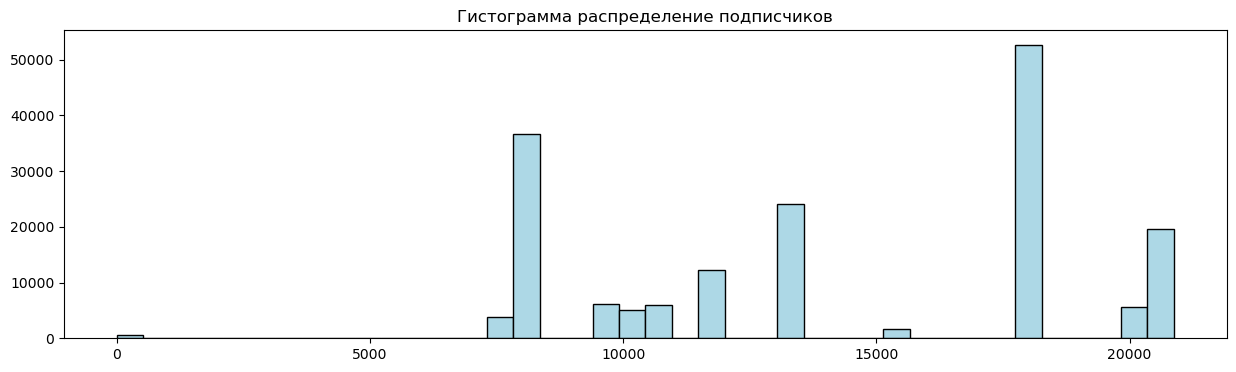

In [14]:
follower_counts = df.select('follower_count').rdd.flatMap(lambda x: x).collect()
fig, axs = plt.subplots(figsize=(15, 4))

axs.hist(follower_counts, bins=40, color='lightblue', edgecolor='black')
axs.set_title('Гистограмма распределение подписчиков')

(array([16635., 12336.,  6067.,  1596.,     0., 11988.,  6027.,     0.,
            0.,     0.,     0.,     0.,  5531.,     0., 41013.,     0.,
            0.,     0.,     0.,     0., 36686.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
        11610.,  5154.,     0.,     0.,     0.,     0.,     0., 19623.]),
 array([    0.  ,   300.55,   601.1 ,   901.65,  1202.2 ,  1502.75,
         1803.3 ,  2103.85,  2404.4 ,  2704.95,  3005.5 ,  3306.05,
         3606.6 ,  3907.15,  4207.7 ,  4508.25,  4808.8 ,  5109.35,
         5409.9 ,  5710.45,  6011.  ,  6311.55,  6612.1 ,  6912.65,
         7213.2 ,  7513.75,  7814.3 ,  8114.85,  8415.4 ,  8715.95,
         9016.5 ,  9317.05,  9617.6 ,  9918.15, 10218.7 , 10519.25,
        10819.8 , 11120.35, 11420.9 , 11721.45, 12022.  ]),
 <BarContainer object of 40 artists>)

Text(0.5, 1.0, 'Гистограмма распределение подписок')

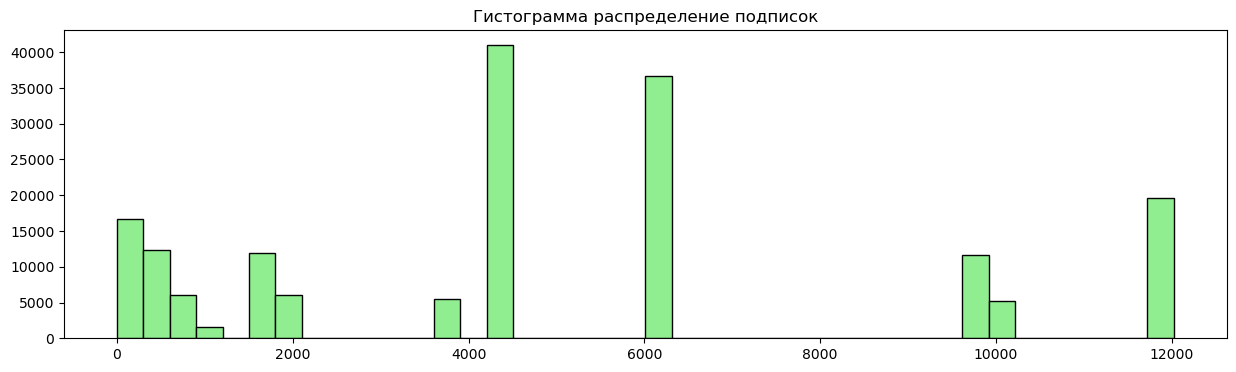

In [15]:
following_counts = df.select('following_count').rdd.flatMap(lambda x: x).collect()
fig, axs = plt.subplots(figsize=(15, 4))
axs.hist(following_counts, bins=40, color='lightgreen', edgecolor='black')
axs.set_title('Гистограмма распределение подписок')

(array([1.74229e+05, 2.20000e+01, 5.00000e+00, 0.00000e+00, 2.00000e+00,
        1.00000e+00, 2.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([  0. ,  16.7,  33.4,  50.1,  66.8,  83.5, 100.2, 116.9, 133.6,
        150.3, 167. , 183.7, 200.4, 217.1, 233.8, 250.5, 267.2, 283.9,
        300.6, 317.3, 334. , 350.7, 367.4, 384.1, 400.8, 417.5, 434.2,
        450.9, 467.6, 484.3, 501. , 517.7, 534.4, 551.1, 567.8, 584.5,
        601.2, 617.9, 634.6, 651.3, 668. ]),
 <BarContainer object of 40 artists>)

Text(0.5, 1.0, 'Гистограмма распределение цитирований')

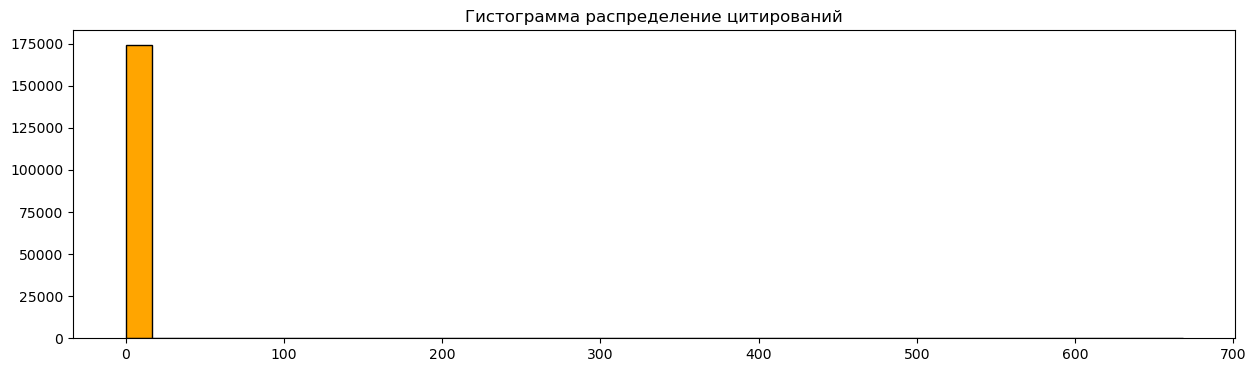

In [16]:
quote_counts = df.select('quote_count').rdd.flatMap(lambda x: x).collect()
fig, axs = plt.subplots(figsize=(15, 4))
axs.hist(quote_counts, bins=40, color='orange', edgecolor='black')
axs.set_title('Гистограмма распределение цитирований')

(array([1.74044e+05, 1.36000e+02, 4.30000e+01, 1.50000e+01, 1.20000e+01,
        4.00000e+00, 1.00000e+00, 1.00000e+00, 3.00000e+00, 1.00000e+00,
        0.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([   0. ,   28.9,   57.8,   86.7,  115.6,  144.5,  173.4,  202.3,
         231.2,  260.1,  289. ,  317.9,  346.8,  375.7,  404.6,  433.5,
         462.4,  491.3,  520.2,  549.1,  578. ,  606.9,  635.8,  664.7,
         693.6,  722.5,  751.4,  780.3,  809.2,  838.1,  867. ,  895.9,
         924.8,  953.7,  982.6, 1011.5, 1040.4, 1069.3, 1098.2, 1127.1,
        1156. ]),
 <BarContainer object of 40 artists>

Text(0.5, 1.0, 'Гистограмма распределение ответов')

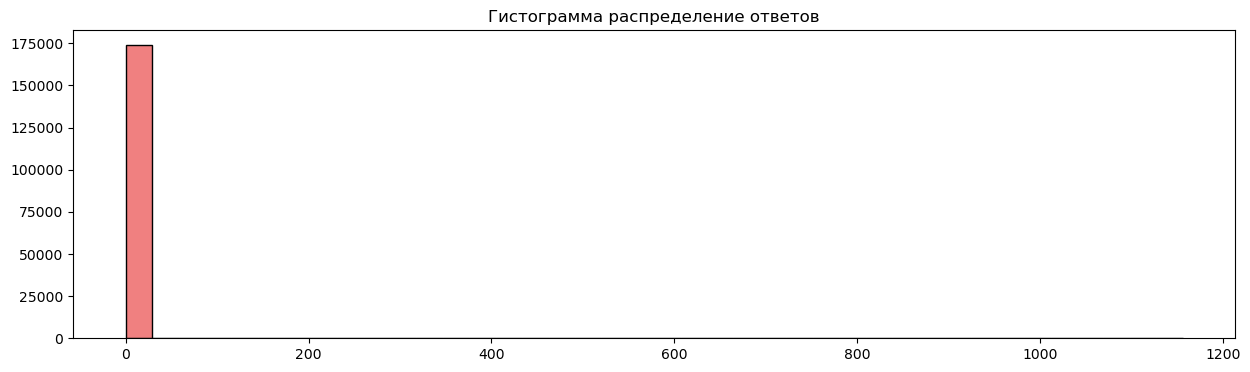

In [17]:
reply_counts = df.select('reply_count').rdd.flatMap(lambda x: x).collect()
fig, axs = plt.subplots(figsize=(15, 4))
axs.hist(reply_counts, bins=40, color='lightcoral', edgecolor='black')
axs.set_title('Гистограмма распределение ответов')

(array([1.72164e+05, 9.96000e+02, 4.42000e+02, 2.29000e+02, 1.30000e+02,
        6.60000e+01, 5.60000e+01, 3.50000e+01, 1.80000e+01, 3.00000e+00,
        4.70000e+01, 2.50000e+01, 9.00000e+00, 1.10000e+01, 7.00000e+00,
        7.00000e+00, 2.00000e+00, 3.00000e+00, 2.00000e+00, 0.00000e+00,
        2.00000e+00, 4.00000e+00, 3.00000e+00, 1.00000e+00, 1.00000e+00,
        2.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([   0. ,   87.7,  175.4,  263.1,  350.8,  438.5,  526.2,  613.9,
         701.6,  789.3,  877. ,  964.7, 1052.4, 1140.1, 1227.8, 1315.5,
        1403.2, 1490.9, 1578.6, 1666.3, 1754. , 1841.7, 1929.4, 2017.1,
        2104.8, 2192.5, 2280.2, 2367.9, 2455.6, 2543.3, 2631. , 2718.7,
        2806.4, 2894.1, 2981.8, 3069.5, 3157.2, 3244.9, 3332.6, 3420.3,
        3508. ]),
 <BarContainer object of 40 artists>

Text(0.5, 1.0, 'Гистограмма распределение лайков')

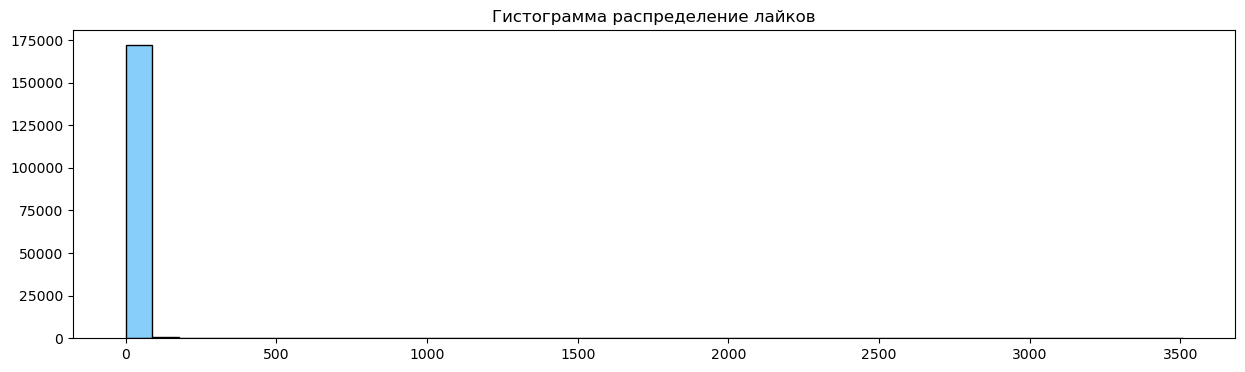

In [18]:
like_counts = df.select('like_count').rdd.flatMap(lambda x: x).collect()
fig, axs = plt.subplots(figsize=(15, 4))
axs.hist(like_counts, bins=40, color='lightskyblue', edgecolor='black')
axs.set_title('Гистограмма распределение лайков')

(array([1.72797e+05, 5.70000e+02, 2.82000e+02, 2.03000e+02, 1.24000e+02,
        6.90000e+01, 4.80000e+01, 3.00000e+01, 2.40000e+01, 2.30000e+01,
        2.10000e+01, 1.40000e+01, 1.30000e+01, 1.30000e+01, 5.00000e+00,
        8.00000e+00, 5.00000e+00, 2.00000e+00, 1.00000e+00, 2.00000e+00,
        2.00000e+00, 2.00000e+00, 2.00000e+00, 2.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([  0. ,  11.5,  23. ,  34.5,  46. ,  57.5,  69. ,  80.5,  92. ,
        103.5, 115. , 126.5, 138. , 149.5, 161. , 172.5, 184. , 195.5,
        207. , 218.5, 230. , 241.5, 253. , 264.5, 276. , 287.5, 299. ,
        310.5, 322. , 333.5, 345. , 356.5, 368. , 379.5, 391. , 402.5,
        414. , 425.5, 437. , 448.5, 460. ]),
 <BarContainer object of 40 artists>)

Text(0.5, 1.0, 'Гистограмма распределение ретвитов')

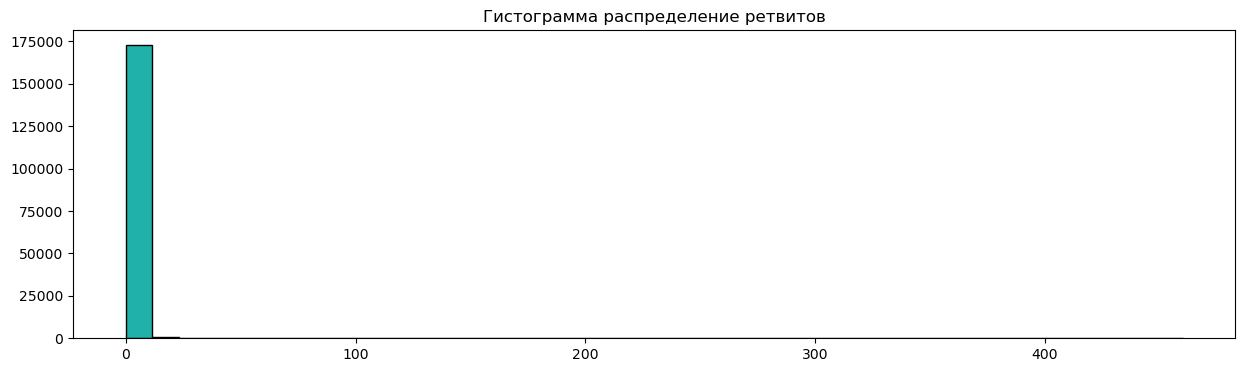

In [19]:
retweet_counts = df.select('retweet_count').rdd.flatMap(lambda x: x).collect()
fig, axs = plt.subplots(figsize=(15, 4))
axs.hist(retweet_counts, bins=40, color='lightseagreen', edgecolor='black')
axs.set_title('Гистограмма распределение ретвитов')

2. Круговая диграмма распределения бинарного признака:

<Figure size 500x500 with 0 Axes>

([<matplotlib.patches.Wedge at 0x7f3e30c1fa90>,
 [Text(-0.4821017292695106, -0.9887254030494754, 'True'),
  Text(0.4821017292695107, 0.9887254030494753, 'False')],
 [Text(-0.26296457960155123, -0.5393047652997138, '57.8%'),
  Text(0.2629645796015513, 0.5393047652997137, '42.2%')])

(-1.0999985552098335,
 1.0999928511193444,
 -1.0999996613780405,
 1.0999928889388937)

Text(0.5, 1.0, 'Соотношение ретвит или нет')

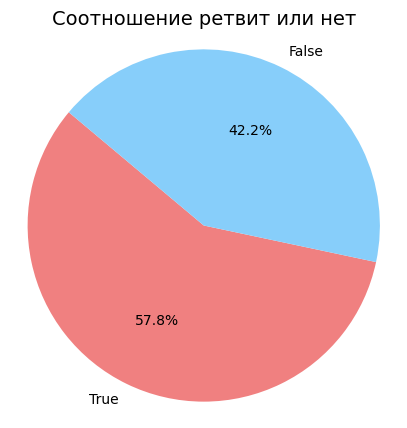

In [20]:
# Создание круговой диаграммы для определения соотношения ретвитов
plt.figure(figsize=(5, 5))
retweet_counts = df.groupBy("is_retweet").count().collect()

labels = [str(row['is_retweet']) for row in retweet_counts]
sizes = [int(row['count']) for row in retweet_counts]
colors = ['lightcoral', 'lightskyblue']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Соотношение ретвит или нет', fontsize=14)
plt.show()

3. Диаграммы распределения рассеиваний количественных показателей для выявления особенностей:

<Figure size 1100x700 with 0 Axes>

Text(0.5, 1.0, 'Диаграмма рассеивания количества лайков и количества ретвитов')

Text(0.5, 0, 'Количество лайков')

Text(0, 0.5, 'Количество ретвитов')

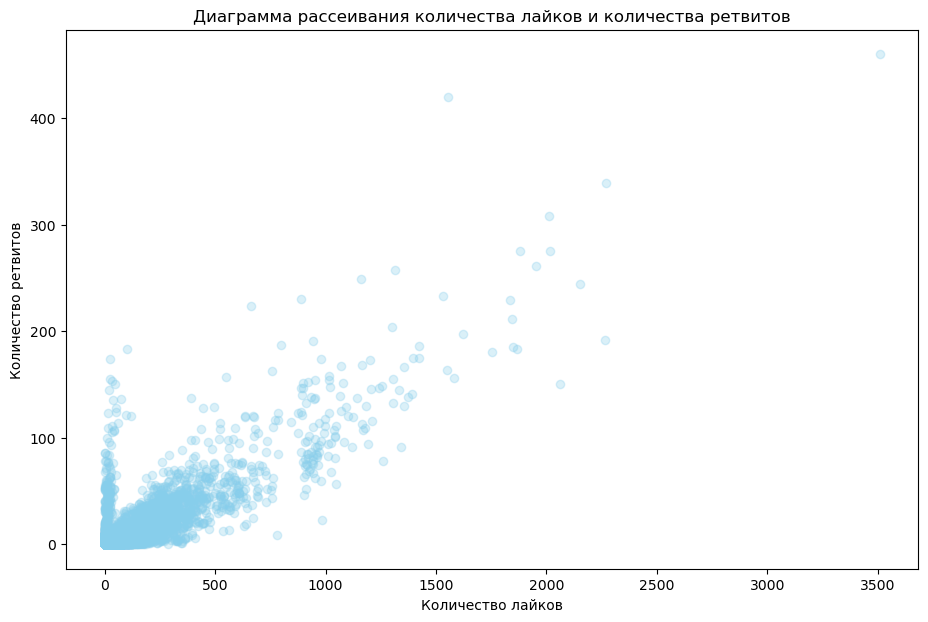

<Figure size 1100x700 with 0 Axes>

Text(0.5, 1.0, 'Диаграмма рассеивания количества ответов и количества цитирований')

Text(0.5, 0, 'Количество ответов')

Text(0, 0.5, 'Количество цитирований')

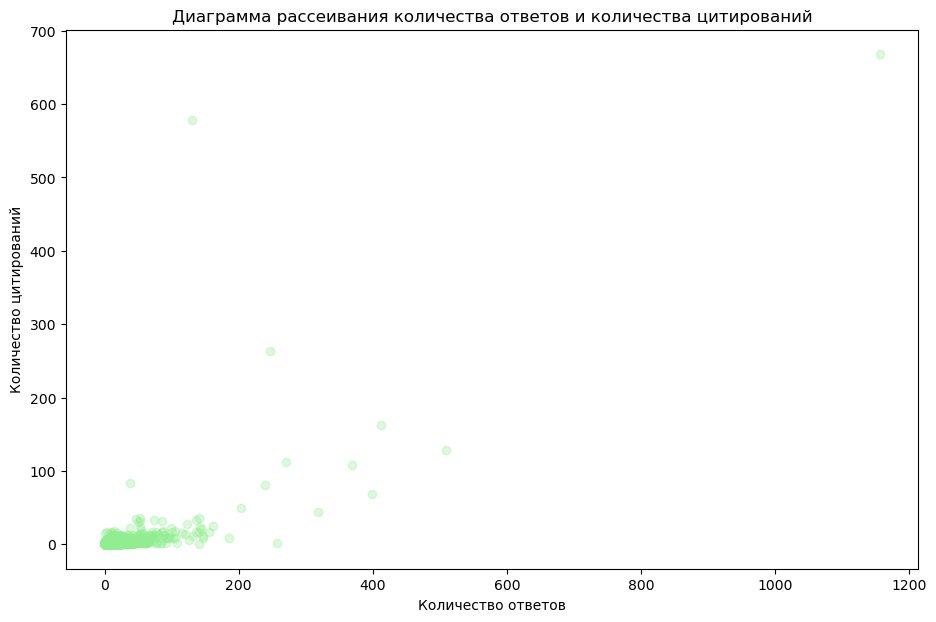

<Figure size 1100x700 with 0 Axes>

Text(0.5, 1.0, 'Диаграмма рассеивания подписок лайков и количества подписчиков')

Text(0.5, 0, 'Количество подписок')

Text(0, 0.5, 'Количество подписчиков')

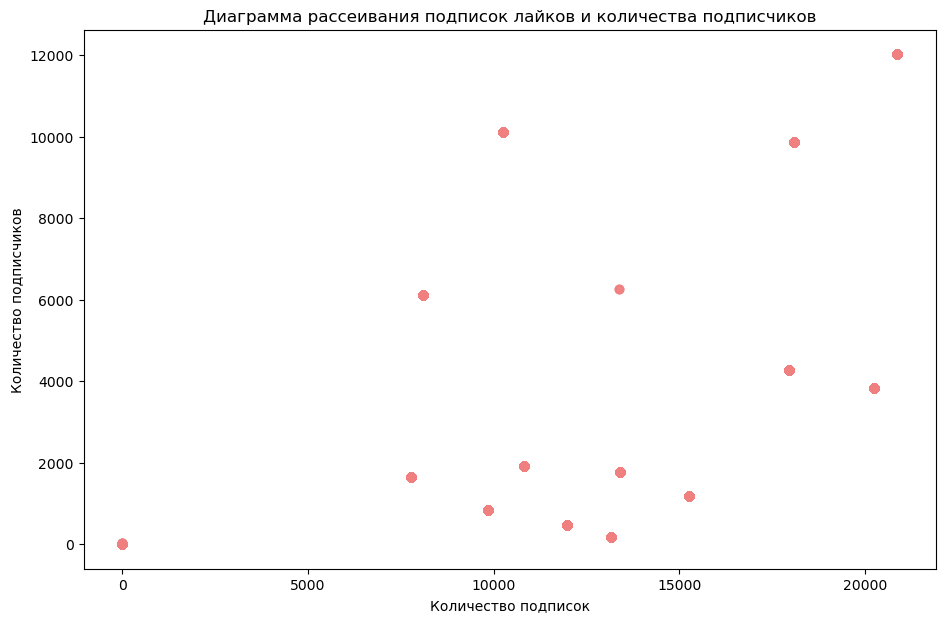

<Figure size 1100x700 with 0 Axes>

Text(0.5, 1.0, 'Диаграмма рассеивания количества подписок и количества лайков')

Text(0.5, 0, 'Количество подписок')

Text(0, 0.5, 'Количество лайков')

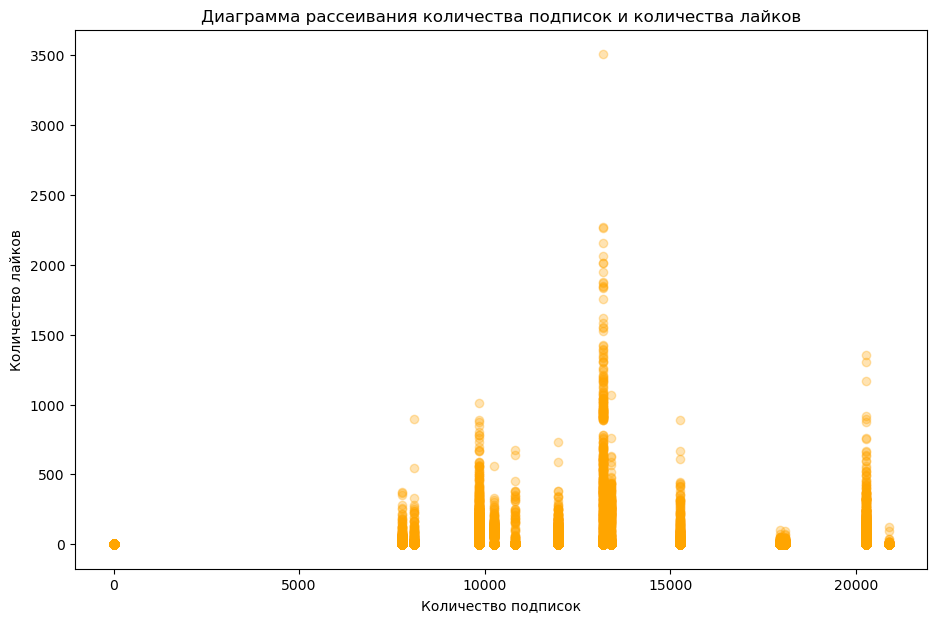

<Figure size 1100x700 with 0 Axes>

Text(0.5, 1.0, 'Диаграмма рассеивания количества лайков и количества ответов')

Text(0.5, 0, 'Количество лайков')

Text(0, 0.5, 'Количество ответов')

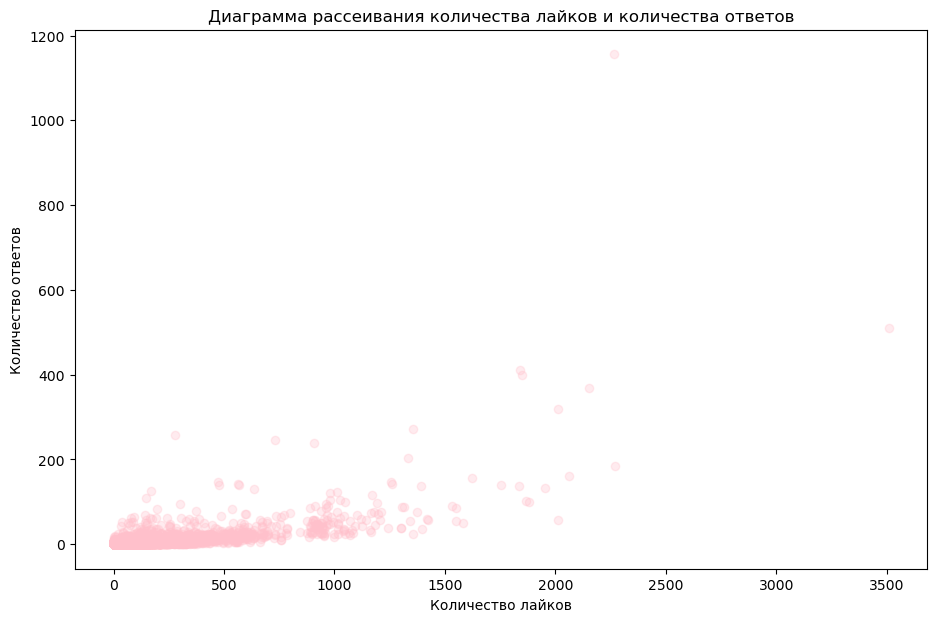

In [21]:
# Преобразование DataFrame в Pandas DataFrame
df_pd = df.select(df.like_count, df.retweet_count).toPandas()

# Построение диаграммы рассеяния
plt.figure(figsize=(11, 7))
plt.scatter(df_pd['like_count'], df_pd['retweet_count'], alpha=0.3, color='skyblue')
plt.title('Диаграмма рассеивания количества лайков и количества ретвитов')
plt.xlabel('Количество лайков')
plt.ylabel('Количество ретвитов')
plt.show()

# Преобразование DataFrame в Pandas DataFrame
df_pd = df.select(df.reply_count, df.quote_count).toPandas()

# Построение диаграммы рассеяния
plt.figure(figsize=(11, 7))
plt.scatter(df_pd['reply_count'], df_pd['quote_count'], alpha=0.3, color='lightgreen')
plt.title('Диаграмма рассеивания количества ответов и количества цитирований')
plt.xlabel('Количество ответов')
plt.ylabel('Количество цитирований')
plt.show()

# Преобразование DataFrame в Pandas DataFrame
df_pd = df.select(df.follower_count, df.following_count).toPandas()

# Построение диаграммы рассеяния
plt.figure(figsize=(11, 7))
plt.scatter(df_pd['follower_count'], df_pd['following_count'], alpha=0.3, color='lightcoral')
plt.title('Диаграмма рассеивания подписок лайков и количества подписчиков')
plt.xlabel('Количество подписок')
plt.ylabel('Количество подписчиков')
plt.show()

# Преобразование DataFrame в Pandas DataFrame
df_pd = df.select(df.follower_count, df.like_count).toPandas()

# Построение диаграммы рассеяния
plt.figure(figsize=(11, 7))
plt.scatter(df_pd['follower_count'], df_pd['like_count'], alpha=0.3, color='orange')
plt.title('Диаграмма рассеивания количества подписок и количества лайков')
plt.xlabel('Количество подписок')
plt.ylabel('Количество лайков')
plt.show()

# Преобразование DataFrame в Pandas DataFrame
df_pd = df.select(df.like_count, df.reply_count).toPandas()

# Построение диаграммы рассеяния
plt.figure(figsize=(11, 7))
plt.scatter(df_pd['like_count'], df_pd['reply_count'], alpha=0.3, color='pink')
plt.title('Диаграмма рассеивания количества лайков и количества ответов')
plt.xlabel('Количество лайков')
plt.ylabel('Количество ответов')
plt.show()

#### 6. Корреляций между признаками:

##### Поля "tweetid" и "userid" нет необходимости включать в списки для анализа корреляции. Идентификаторы обычно не имеют значения для анализа корреляций и могут даже помешать получению точных результатов.

##### Корреляция можно посчитать только у количественных признаков. В данной работе их шесть:
1. 'follower_count' - Количество подписчиков

2. 'following_count' - Количество подписок

3. 'quote_count' - Количество цитирований

4. 'reply_count' - Количество ответов

5. 'like_count' - Количество лайков

6. 'retweet_count' - Количество ретвитов

In [22]:
df.columns
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

['tweetid',
 'userid',
 'follower_count',
 'following_count',
 'tweet_language',
 'is_retweet',
 'quote_count',
 'reply_count',
 'like_count',
 'retweet_count']

Columns overview


,Column Name,Data type
0,tweetid,bigint
1,userid,bigint
2,follower_count,int
3,following_count,int
4,tweet_language,string
5,is_retweet,boolean
6,quote_count,int
7,reply_count,int
8,like_count,int
9,retweet_count,int


In [23]:
columns_to_exclude = ['tweetid', 'userid', 'user_reported_location', 'account_creation_date', 'tweet_language']
list_columns = [column for column in df.columns if column not in columns_to_exclude]
assembler = VectorAssembler(inputCols=list_columns, outputCol="features")
assembler.setHandleInvalid("skip")
df_vector = assembler.transform(df).select("features")

VectorAssembler_808566eca958

In [24]:
matrix = Correlation.corr(df_vector, "features").collect()[0][0]
corrmatrix = matrix.toArray().tolist()
columns = ['follower_count', 'following_count', 'quote_count', 'reply_count', 'like_count', 'retweet_count']
df_corr = spark.createDataFrame(corrmatrix, columns)
df_corr.select(
    round('follower_count', 3).alias('follower_count'),
    round('following_count', 3).alias('following_count'),
    round('quote_count', 3).alias('quote_count'),
    round('reply_count', 3).alias('reply_count'),
    round('like_count', 3).alias('like_count'),
    round('retweet_count', 3).alias('retweet_count')
).show()

+--------------+---------------+-----------+-----------+----------+-------------+
|follower_count|following_count|quote_count|reply_count|like_count|retweet_count|
+--------------+---------------+-----------+-----------+----------+-------------+
|           1.0|           0.38|      0.101|      0.001|    -0.016|        -0.02|
|          0.38|            1.0|      0.406|     -0.015|    -0.063|       -0.096|
|         0.101|          0.406|        1.0|     -0.021|    -0.102|        -0.13|
|         0.001|         -0.015|     -0.021|        1.0|     0.707|        0.302|
|        -0.016|         -0.063|     -0.102|      0.707|       1.0|        0.654|
|         -0.02|         -0.096|      -0.13|      0.302|     0.654|          1.0|
|          0.01|         -0.057|     -0.111|      0.241|     0.544|        0.857|
+--------------+---------------+-----------+-----------+----------+-------------+



##### Cильная связь имеется у признаков "follower_count (число подписчиков)" и "following_count (число подписок)". Это говорит о том, что при увеличении одного признака, другой, с большей вероятность будет увеличиваться. 
##### При увеличении признака "follower_count (число подписчиков)" признак "quote_count (число цитирований)" может быть увеличен. А при увеличении "following_count (число подписок) признак также может быть увеличен.
##### Обнаружено множество отрицательных корреляций.
##### У колонок "reply_count", "like_count", "retweet_count" корреляция между друг другом равна 1, т.к. данные по всем строкам датасета одиннаковы равны друг другу.
##### Корреляции "диагональных" признаков всегда равны 1, т.к. это и есть те же самые признаки и они всегда будут изменяться, если их изменяют.

### Сохранение результатов анализа:

##### Сохраним обработанный датасет для дальнейшей работы, а именно создания модели для машинного обучения:

In [25]:
df = df.withColumn("follower_count", col("follower_count").cast(DoubleType()))
df = df.withColumn("following_count", col("following_count").cast(DoubleType()))
df = df.withColumn("quote_count", col("like_count").cast(DoubleType()))
df = df.withColumn("reply_count", col("like_count").cast(DoubleType()))
df = df.withColumn("like_count", col("like_count").cast(DoubleType()))
df = df.withColumn("retweet_count", col("like_count").cast(DoubleType()))

processed_filename_data = "processed_" + filename_data
df.coalesce(1).write.option("header", "true").csv(processed_filename_data)

##### Проверим сохраненный датасет на сохранение типов признаков и количества строк:

In [26]:
df = spark.read.csv(processed_filename_data, header=True, mode="DROPMALFORMED", inferSchema=True)
print('Data overview')
df.printSchema()
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])
total_twitter_count = df.count()
print('Rows count:')
total_twitter_count

Data overview
root
 |-- tweetid: long (nullable = true)
 |-- userid: long (nullable = true)
 |-- follower_count: double (nullable = true)
 |-- following_count: double (nullable = true)
 |-- tweet_language: string (nullable = true)
 |-- is_retweet: boolean (nullable = true)
 |-- quote_count: double (nullable = true)
 |-- reply_count: double (nullable = true)
 |-- like_count: double (nullable = true)
 |-- retweet_count: double (nullable = true)

Columns overview


,Column Name,Data type
0,tweetid,bigint
1,userid,bigint
2,follower_count,double
3,following_count,double
4,tweet_language,string
5,is_retweet,boolean
6,quote_count,double
7,reply_count,double
8,like_count,double
9,retweet_count,double


Rows count:


174266

### Выводы:

##### В ходе лабораторной работы был изучен функционал Apache PySpark. Я научился пользоваться функционалом Apache Spark благодаря Python API - PySpark. Целью работы было провести разведочный анализ датасета. В ходе работы были выполнены данные пункты:
1. Типы признаков в датасете: Определил, какие данные включены в датасет (числовые, категориальные и бинарные).

2. Пропущенные значения и их устранения: Определил наличие пропущенных значений в данных и их устранил. Строки с пропущенными значениями было решено полностью удалить.

3. Выбросы и их устранения: Провел работу по устранению выбросов используя метод межквартильного интервала, а после проверил их отсутствие с помощью boxspot-ов.

4. Расчет статистических показателей признаков (средних, квартилей и т.д.): Провел расчёт статистических показателей категориальных, бинарных и числовых признаков, которые включают: средние значения, медианы, квартили, моды, стандартные отклонения, диапозоны значений, квантили, процентные соотношения и другие характеристики, чтобы лучше понять распределение данных.

5. Визуализация распределения наиболее важных признаков: Выполнил визуализацию распределения наиболее важных признаков. Визуализация помогает визуально оценить данные и выявить особенности.

6. Корреляция между признаками: Исследовал корреляции между признаками, позволяющие понять, какие признаки взаимосвязаны между собой, а какие – нет.

##### Разведочный анализ помогает лучше понять характеристики датасета, подготовить данные для построения моделей (для выполнения ЛР №2) и выявить интересные закономерности, которые могут стать основой для более глубокого исследования.